In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

# 生成数据集
我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征x，我们使用如下的三阶多项式函数来生成该样本的标签：
                y=1.2x−3.4x<sup>2</sup>+5.6x<sup>3</sup>+5+ϵ，
其中噪声项ϵ服从均值为0、标准差为0.01的正态分布。训练数据集和测试数据集的样本数都设为100。

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

看一看生成的数据集的前两个样本。

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 0.9337],
         [-0.8390]]),
 tensor([[ 0.9337,  0.8718,  0.8140],
         [-0.8390,  0.7040, -0.5907]]),
 tensor([ 7.7265, -1.7028]))

# 定义、训练和测试模型
我们先定义作图函数`semilogy`，其中 y 轴使用了对数尺度。

In [4]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=":")
        d2l.plt.legend(legend)

和线性回归一样，多项式函数拟合也使用平方损失函数。因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在`fit_and_plot`函数中。多项式函数拟合的训练和测试步骤与3.6节（softmax回归的从零开始实现）介绍的softmax回归中的相关步骤类似。

In [5]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)  # 打包，类似于zip()
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test_loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

# 三阶多项式函数拟合(正常)
我们先使用与数据生成函数同阶的三阶多项式函数拟合。实验表明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值：w1=1.2,w2=−3.4,w3=5.6,b=5。

final epoch: train loss 0.00010785200720420107 test_loss 0.00011855230695800856
weight: tensor([[ 1.2034, -3.4010,  5.5998]]) 
bias: tensor([5.0013])


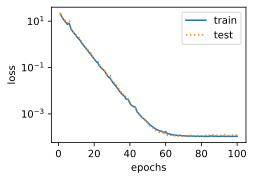

In [6]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

# 线性函数拟合(欠拟合)
我们再试试线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。线性模型在非线性模型（如三阶多项式函数）生成的数据集上容易欠拟合。

final epoch: train loss 166.60890197753906 test_loss 232.98086547851562
weight: tensor([[17.2366]]) 
bias: tensor([1.3923])


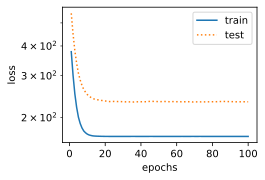

In [7]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

# 训练样本不足(过拟合)
事实上，即便使用与数据生成模型同阶的三阶多项式函数模型，如果训练样本不足，该模型依然容易过拟合。让我们只使用两个样本来训练模型。显然，训练样本过少了，甚至少于模型参数的数量。这使模型显得过于复杂，以至于容易被训练数据中的噪声影响。在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象。

final epoch: train loss 0.07726443558931351 test_loss 173.42840576171875
weight: tensor([[2.9262, 0.9151, 2.5169]]) 
bias: tensor([1.8416])


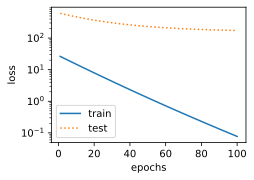

In [8]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

# 小结
+ 由于无法从训练误差估计泛化误差，一味地降低训练误差并不意味着泛化误差一定会降低。机器学习模型应关注降低泛化误差。
+ 可以使用验证数据集来进行模型选择。
+ 欠拟合指模型无法得到较低的训练误差，过拟合指模型的训练误差远小于它在测试数据集上的误差。
+ 应选择复杂度合适的模型并避免使用过少的训练样本。